In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 5.6 MB/s eta 0:00:00


In [7]:
# imports

import glob
import math
import os
import pickle
import random
import tempfile
import time
import urllib
from datetime import datetime, timedelta
from io import StringIO
from typing import List
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import pytz
import seaborn as sns
import torch
from pandas.plotting import register_matplotlib_converters
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

register_matplotlib_converters()
%matplotlib inline
sns.set_style("whitegrid")

2023-04-14 12:28:20.321738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# load preprocessed data from 10 nodes in the bay area

#df = pd.read_csv("/content/drive/MyDrive/Data 298A/Improvement/processed.csv")
df = pd.read_csv('processed (1).csv')

In [9]:
df = df.drop(
    [
        "Unnamed: 0",
        "INTERVALENDTIME_GMT",
        "OPR_DT",
        "OPR_HR",
        "NODE_ID_XML",
        "NODE_ID",
        "NODE",
        "MARKET_RUN_ID",
        "LMP_TYPE",
        "XML_DATA_ITEM",
        "PNODE_RESMRID",
        "GRP_TYPE",
    ],
    axis=1,
)

In [10]:
df.head()

,INTERVALSTARTTIME_GMT,POS,VALUE,OPR_INTERVAL,GROUP,HOUR,2DA,7DA,ACTUAL,DAM,ETo (in),Precip (in),Rel Hum (%),Wind Speed (mph),Soil Temp (F)
0,2020-01-01T08:00:00-00:00,1,-0.422382,1,5,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
1,2020-01-01T08:05:00-00:00,1,-0.405158,2,5,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
2,2020-01-01T08:10:00-00:00,1,-0.417772,3,5,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
3,2020-01-01T08:15:00-00:00,1,-0.418884,4,5,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814
4,2020-01-01T08:20:00-00:00,1,-0.414159,5,5,16,-4.146099,-4.113026,-4.485045,-4.307317,-3.023405,-0.03305,3.663296,-1.213782,0.188814


In [11]:
df['INTERVALSTARTTIME_GMT'] = pd.to_datetime(df['INTERVALSTARTTIME_GMT'])

In [12]:
df=df[(df['INTERVALSTARTTIME_GMT'].dt.day_name()!='Saturday') & (df['INTERVALSTARTTIME_GMT'].dt.day_name()!='Sunday')]


In [13]:
train_set_length = int(round((df.shape[0] * 0.75), 0))
test_set_length = df.shape[0] - train_set_length

print(f"\nTrain: {train_set_length} rows\nTest:  {test_set_length} rows")

train = df.iloc[:train_set_length]
test = df.iloc[train_set_length:]

print(f"\nTrain set shape: {train.shape}\nTest set shape:  {test.shape}\n")


Train: 1674000 rows
Test:  558000 rows

Train set shape: (1674000, 15)
Test set shape:  (558000, 15)



In [14]:
train = train.set_index("INTERVALSTARTTIME_GMT")
test = test.set_index("INTERVALSTARTTIME_GMT")

In [15]:
features = [col for col in train.columns if col != "VALUE"]
print(len(features))
print(features)

13
['POS', 'OPR_INTERVAL', 'GROUP', 'HOUR', '2DA', '7DA', 'ACTUAL', 'DAM', 'ETo (in)', 'Precip (in)', 'Rel Hum (%)', 'Wind Speed (mph)', 'Soil Temp (F)']


In [16]:
X_train = train[features]
y_train = train["VALUE"]

X_test = test[features]
y_test = test["VALUE"]

# Classic Machine Learning Models

## Linear Regression

Linear Regression is the most basic regression model.

In [29]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

In [30]:
lr_prediction = lr.predict(X_test)

In [31]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(y_test, lr_prediction))
print(f"RMSE Score on LinearRegression Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, lr_prediction)
print(f"MAE Score on LinearRegression Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, lr_prediction)
print(f"MAPE Score on LinearRegression Test set: {mape:0.3f}")

RMSE Score on LinearRegression Test set: 1.123
MAE Score on LinearRegression Test set: 0.492
MAPE Score on LinearRegression Test set: 1.478


## XGBoost

XGBoost (eXtreme Gradient Boosting) is an open-source software library which provides a regularizing gradient boosting framework. It aims to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library". It runs on a single machine, as well as the distributed processing frameworks Apache Hadoop, Apache Spark, Apache Flink, and Dask.



In [26]:
# Xgboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

gdbt = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=10000,
    early_stopping_rounds=50,
    objective="reg:linear",
    max_depth=10,
    learning_rate=0.01,
)
gdbt.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[12:31:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1679035020608/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.13743	validation_1-rmse:1.18078
[100]	validation_0-rmse:0.99162	validation_1-rmse:1.10848
[200]	validation_0-rmse:0.96142	validation_1-rmse:1.10427
[232]	validation_0-rmse:0.95766	validation_1-rmse:1.10457


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [32]:
gdbt_prediction = gdbt.predict(X_test)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

score = np.sqrt(mse(y_test, gdbt_prediction))
print(f"RMSE Score on XGBRegressor Test set: {score:0.3f}")
mae = mean_absolute_error(y_test, gdbt_prediction)
print(f"MAE Score on XGBRegressor Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(y_test, gdbt_prediction)
print(f"MAPE Score on XGBRegressor Test set: {mape:0.3f}")

RMSE Score on XGBRegressor Test set: 1.104
MAE Score on XGBRegressor Test set: 0.505
MAPE Score on XGBRegressor Test set: 3.153


(558000, 13)
(558000,)


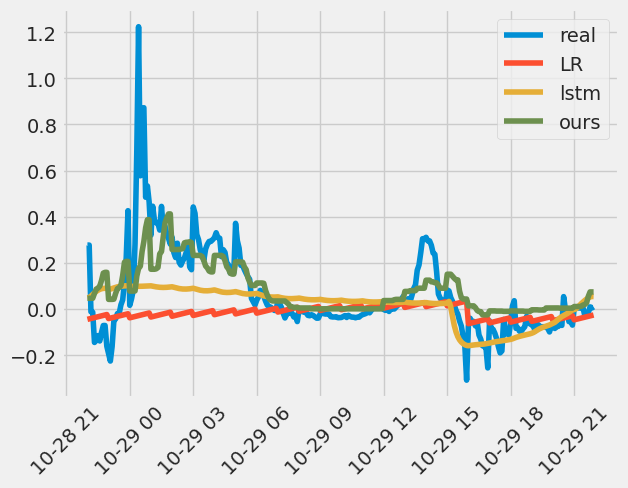

In [65]:
import matplotlib.pyplot as plt

print(X_test.shape)
print(y_test.shape)

start = 60 * 10
end = 60  * 10 + 12 * 24
plt.plot(X_test.index[start:end], y_test[start:end], label='real')
plt.plot(X_test.index[start:end], lr_prediction[start:end], label='LR')
plt.plot(X_test.index[start:end], pred2[start:end], label='lstm')
plt.plot(X_test.index[start:end], gdbt_prediction[start:end], label='ours')


plt.xticks(rotation = 45)
plt.legend()
plt.show()

# Innovative Machine Learning Models

## RNN (LSTM, GRU)

# New Section

In [40]:
import tensorflow as tf
from keras import regularizers
from keras.layers import GRU, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [41]:
# Time Series Generator Parameters

lookback_length = 12
batch_size = 64

In [42]:
train_sequences = TimeseriesGenerator(
    X_train, y_train, length=lookback_length, batch_size=batch_size
)
batch_x, batch_y = train_sequences[0]

In [43]:
test_sequences = TimeseriesGenerator(
    X_test, y_test, length=lookback_length, batch_size=batch_size
)

batch_x_test, batch_y_test = train_sequences[0]

In [44]:
with tf.device("/gpu:0"):
    gru = Sequential()

    gru.add(
        GRU(16, input_shape=(batch_x.shape[1], batch_x.shape[2]), return_sequences=True)
    )

    gru.add(GRU(16))

    gru.add(Dense(32, activation="relu"))
    # model.add(Dropout(0.1))                  # refers to nodes in the first hidden layer

    gru.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.1))

    gru.add(Dense(8, activation="relu"))
    # model.add(Dropout(0.1))

    gru.add(Dense(1, activation="linear"))

    gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 16)            1488      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,337
Trainable params: 4,337
Non-trainabl

In [45]:
# GRU

with tf.device("/gpu:0"):
    gru.compile(optimizer=Adam(lr=0.0005), loss="mean_squared_error")

    history = gru.fit_generator(
        train_sequences,
        validation_data=test_sequences,
        epochs=1,
        verbose=1,
        use_multiprocessing=True,
    )

/home/zyan/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_5234/1283367688.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = gru.fit_generator(


26157/26157 [==============================] - 193s 7ms/step - loss: 1.0435 - val_loss: 1.2410


In [53]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# pred = gru.predict(test_sequences)
score = np.sqrt(mse(pred, y_test[:557988]))
print(f"RMSE Score on GRU Test set: {score:0.3f}")
mae = mean_absolute_error(pred, y_test[:557988])
print(f"MAE Score on GRU Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred, y_test[:557988])
print(f"MAPE Score on GRU Test set: {mape:0.3f}")

RMSE Score on GRU Test set: 1.114
MAE Score on GRU Test set: 0.506
MAPE Score on GRU Test set: 50.203


In [52]:
pred.shape

(557988, 1)

In [61]:
# %%LSTM Model
lstm = Sequential()
lstm.add(
    LSTM(
        120,
        return_sequences=True,
        input_shape=(batch_x.shape[1], batch_x.shape[2]),
    )
)
lstm.add(LSTM(80, return_sequences=True))
lstm.add(LSTM(40))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 120)           64320     
                                                                 
 lstm_1 (LSTM)               (None, 12, 80)            64320     
                                                                 
 lstm_2 (LSTM)               (None, 40)                19360     
                                                                 
 dense_4 (Dense)             (None, 1)                 41        
                                                                 
Total params: 148,041
Trainable params: 148,041
Non-trainable params: 0
_________________________________________________________________


In [62]:
# LSTM
lstm.compile(optimizer=Adam(lr=0.0005), loss="mean_squared_error")

history1 = lstm.fit_generator(
    train_sequences, validation_data=test_sequences, epochs=1, verbose=1
)

/home/zyan/miniconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_5234/515222140.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = lstm.fit_generator(


26157/26157 [==============================] - 131s 5ms/step - loss: 1.0467 - val_loss: 1.2498


In [63]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

pred2 = lstm.predict(test_sequences)
score = np.sqrt(mse(pred2, y_test[:557988]))
print(f"RMSE Score on LSTM Test set: {score:0.3f}")
mae = mean_absolute_error(pred2, y_test[:557988])
print(f"MAE Score on LSTM Test set: {mae:0.3f}")
mape = mean_absolute_percentage_error(pred2, y_test[:557988])
print(f"MAPE Score on LSTM Test set: {mape:0.3f}")

8719/8719 [==============================] - 35s 4ms/step
RMSE Score on LSTM Test set: 1.119
MAE Score on LSTM Test set: 0.496
MAPE Score on LSTM Test set: 24.818


In [46]:
inputs = tf.keras.Input(shape=(12))

lstm_out = lstm(inputs)
gru_out = gru(inputs)
dense = layers.Dense(q)
out = dense(tf.cat([lstm_out, gru_out]))

my_functional_model = tf.keras.Model(inputs=inputs, outputs=out)
my_functional_model.summary()

ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).

Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 12)

Call arguments received by layer "sequential_1" (type Sequential):
  • inputs=tf.Tensor(shape=(None, 12), dtype=float32)
  • training=None
  • mask=None

In [43]:
# LSTM
history1 = ensemble.fit_generator(
    train_sequences, validation_data=test_sequences, epochs=1, verbose=1
)

AttributeError: 'Ensemble' object has no attribute 'fit_generator'

## Our Proposed Model

In [22]:
# dense -> MLP             -\
# sparse -> nn.Embedding   --  MLP


class ElectricyMarketPriceModule(pl.LightningModule):
    def __init__(self):
        super().__init__()

        embedding_dim = 32
        self._dense_mlp = nn.Sequential(
            nn.LazyLinear(32),
            nn.Tanh(),
        )
        self._month_emb = nn.Embedding(12, embedding_dim)
        self._hour_emb = nn.Embedding(24, embedding_dim)
        self._weekday_emb = nn.Embedding(7, embedding_dim)
        self._sparse_mlp = nn.Sequential(
            nn.LazyLinear(32),
            nn.Tanh(),
        )
        # self._transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)
        self._multihead_attn = nn.MultiheadAttention(32 + 32, 8)
        self._over_mlp = nn.Sequential(
            nn.LazyLinear(64),
            nn.Tanh(),
            nn.LazyLinear(6),
        )

        self.loss = nn.MSELoss()

    def training_step(self, batch):
        dense, sparse, label = batch
        # print(f"dense = {dense}")
        # print(f"sparse = {sparse}")
        # print(f"label = {label}")
        # raise Exception()

        B = dense.size(0)
        dense_out = self._dense_mlp(dense)
        month_embs = self._month_emb(sparse[:, :, 0])
        hour_embs = self._hour_emb(sparse[:, :, 1])
        weekday_embs = self._weekday_emb(sparse[:, :, 2])
        sparse_out = self._sparse_mlp(
            torch.cat([month_embs, hour_embs, weekday_embs], dim=-1)
        )
        attn_input = torch.cat([dense_out, sparse_out], dim=-1)
        attn_output, _ = self._multihead_attn(
            attn_input, attn_input, attn_input, need_weights=False
        )  # [B, 288, 68]
        pred = self._over_mlp(attn_output.view(B, -1))
        # print(f'pred {pred}')
        # print(f'label {label}')
        loss = self.loss(pred, label)
        # print(f'loss {loss}')
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.cnn_net(x)
        out = out.view(x.size(0), -1)
        pred = self.linear_net(out)
        pred = torch.argmax(pred, dim=1)
        self.log("val_loss", (pred == y).sum().item() / x.size(0), prog_bar=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.cnn_net(x)
        out = out.view(x.size(0), -1)
        pred = self.linear_net(out)
        pred = torch.argmax(pred, dim=1)
        self.log("test_loss", (pred == y).sum().item() / x.size(0))

    def predict_step(self, batch, batch_idx):
        dense, sparse, label = batch
        # print(f"dense = {dense}")
        # print(f"sparse = {sparse}")
        # print(f"label = {label}")
        # raise Exception()

        B = dense.size(0)
        dense_out = self._dense_mlp(dense)
        month_embs = self._month_emb(sparse[:, :, 0])
        hour_embs = self._hour_emb(sparse[:, :, 1])
        weekday_embs = self._weekday_emb(sparse[:, :, 2])
        sparse_out = self._sparse_mlp(
            torch.cat([month_embs, hour_embs, weekday_embs], dim=-1)
        )
        attn_input = torch.cat([dense_out, sparse_out], dim=-1)
        attn_output, _ = self._multihead_attn(
            attn_input, attn_input, attn_input, need_weights=False
        )  # [B, 288, 68]
        pred = self._over_mlp(attn_output.view(B, -1))
        return pred, label

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer, gamma=0.95, verbose=True
        )
        return [optimizer], [lr_scheduler]

In [51]:
class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, df, years: List[int]):
        super(MyIterableDataset).__init__()

        self._df = df

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        assert (
            worker_info is None
        )  # single-process data loading, return the full iterator

        price_list: List[float] = []
        dense_list: List[List[float]] = []
        month_list: List[int] = []
        hour_list: List[int] = []
        weekday_list: List[int] = []

        for index, row in self._df.iterrows():
            # 24 hours for training, 1 hour for ground truth
            if len(price_list) == 24 * 12 + 12 * 24:
                indices = list(range(0, 24 * 12, 12))
                yield torch.tensor(
                    [dense_list[i] for i in indices], dtype=torch.float
                ), torch.tensor(
                    list(
                        zip(
                            [month_list[i] for i in indices],
                            [hour_list[i] for i in indices],
                            [weekday_list[i] for i in indices],
                        )
                    ),
                    dtype=torch.int,
                ), torch.tensor(
                    [
                        price_list[24 * 12],
                        price_list[24 * 12 + 11],
                        price_list[24 * 12 + 12 * 2 - 1],
                        price_list[24 * 12 + 12 * 4 - 1],
                        price_list[24 * 12 + 12 * 12 - 1],
                        price_list[24 * 12 + 12 * 24 - 1],
                    ],
                    dtype=torch.float,
                ),

                # 5 minutes, one hour, 2 hours, 4 hours, 12 hours, 24 hours

                price_list.pop(0)
                dense_list.pop(0)
                month_list.pop(0)
                hour_list.pop(0)
                weekday_list.pop(0)

           
            try:
              curt_dt = datetime.strptime(
                  str(row["INTERVALSTARTTIME_GMT"]), "%Y-%m-%dT%H:%M:00-00:00"
              ) + timedelta(hours=8)
            except: 
              continue
            price_list.append(float(row["VALUE"]))
            dense_list.append([float(row["VALUE"])] + row[df.columns[-9:]].tolist())
            month_list.append(curt_dt.month - 1)
            hour_list.append(curt_dt.hour)
            weekday_list.append(curt_dt.weekday())


train_dataset = MyIterableDataset(df, years=[2020, 2021, 2022])
test_dataset = MyIterableDataset(df, years=[2023])

In [54]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        print(f'linear {m}')
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.Embedding):
        print(f'embedding {m}')
        nn.init.uniform_(m.weight, -1.0, 1.0)

module = ElectricyMarketPriceModule()



/home/zyan/miniconda3/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [55]:
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [56]:
batch = next(iter(DataLoader(train_dataset, batch_size=32)))


In [57]:
module.training_step(batch)
module.apply(init_weights)
module.training_step(batch)

linear Linear(in_features=10, out_features=32, bias=True)
embedding Embedding(12, 32)
embedding Embedding(24, 32)
embedding Embedding(7, 32)
linear Linear(in_features=96, out_features=32, bias=True)
linear NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
linear Linear(in_features=1536, out_features=64, bias=True)
linear Linear(in_features=64, out_features=6, bias=True)


/home/zyan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/core/module.py:410: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
/tmp/ipykernel_6018/3358660829.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


tensor(0.3491, grad_fn=<MseLossBackward0>)

In [41]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")
trainer = pl.Trainer(
    max_epochs=1,
    callbacks=[lr_monitor],
    logger=TensorBoardLogger("tb_logs", name="my_model"),
    accelerator="gpu",  # accelerator="gpu",
)
trainer.fit(module, DataLoader(train_dataset, batch_size=1024))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zyan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type               | Params
-------------------------------------------------------
0 | _dense_mlp      | Sequential         | 352   
1 | _month_emb      | Embedding          | 384   
2 | _hour

Adjusting learning rate of group 0 to 1.0000e-02.


/home/zyan/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 9.5000e-03.
Adjusting learning rate of group 0 to 9.0250e-03.
Adjusting learning rate of group 0 to 8.5737e-03.
Adjusting learning rate of group 0 to 8.1451e-03.


`Trainer.fit` stopped: `max_epochs=5` reached.


Adjusting learning rate of group 0 to 7.7378e-03.


In [52]:
res = trainer.predict(module, DataLoader(test_dataset, batch_size=512))

You are using a CUDA device ('NVIDIA Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [53]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

mses = []
maes = []
mapes = []

for r in res:
    pred, test = r
    mses.append(np.sqrt(mse(pred, test)))
    maes.append(mean_absolute_error(pred, test))
    mapes.append(mean_absolute_percentage_error(pred, test))

print(f"RMSE Score on Transformer Test set: {sum(mses)/len(mses):0.3f}")
print(f"MAE Score on Transformer Test set: {sum(maes)/len(maes):0.3f}")
print(f"MAPE Score on Transformer Test set: {sum(mapes)/len(mapes):0.3f}")


RMSE Score on Transformer Test set: 0.569
MAE Score on Transformer Test set: 0.375
MAPE Score on Transformer Test set: 11.503


## Trading

In [ ]:
# baseline: buy at at 9pm - 9am, sell at 9am - 9pm

balance = 0.0
charged = 0.0
naive_dts = []
naive_balances = []
naive_remainings = []

CAPACITY = 13.3
CHARGE_SPEED = 3.3

price_list: List[float] = []
month_list: List[int] = []
hour_list: List[int] = []
weekday_list: List[int] = []


pbar = tqdm(df.iterrows())
for index, row in pbar:
    price = float(row["VALUE"])
    price_list.append(float(row["VALUE"]))
    curt_dt = datetime.strptime(
        row["INTERVALSTARTTIME_GMT"], "%Y-%m-%dT%H:%M:00-00:00"
    ) + timedelta(hours=8)
    month_list.append(curt_dt.month - 1)
    hour_list.append(curt_dt.hour)
    weekday_list.append(curt_dt.weekday())

    if curt_dt.year != 2022:
        if curt_dt.hour == 0:
            pbar.set_description(f"{curt_dt}")
        continue

    # trade at minute 0
    if curt_dt.minute == 0:
        naive_dts.append(curt_dt)
        naive_balances.append(balance)
        naive_remainings.append(charged)

        if curt_dt.hour >= 9 and curt_dt.hour < 21:
            if charged > 0:
                balance += price * (CAPACITY / 12)
                charged -= CAPACITY / 12
        else:
            if charged < CAPACITY:
                balance -= price * (CAPACITY / 12)
                charged += CAPACITY / 12

        if curt_dt.hour == 0:
            pbar.set_description(f"{curt_dt} {balance}")

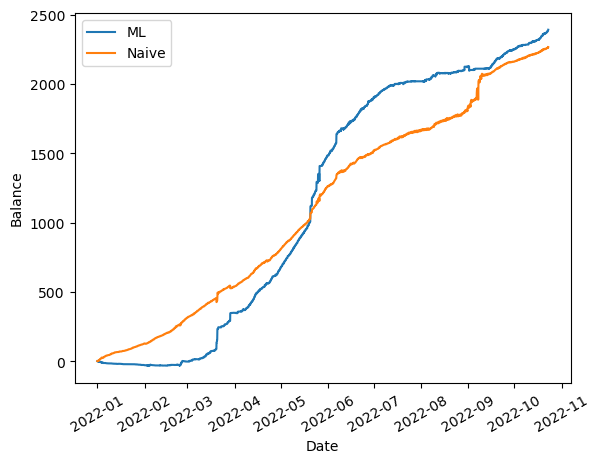

In [ ]:
import matplotlib.pyplot as plt

plt.plot(dts, balances, label="ML")
plt.plot(naive_dts, naive_balances, label="Naive")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Balance")
plt.legend()
plt.show()